In [109]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
from gym import spaces
import copy
import os

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.callbacks import BaseCallback

In [110]:
#Pull in testing data
test = pickle.load(open('test_ta', 'rb'))
train = pickle.load(open('train_ta', 'rb'))

#Technical indicators list. TODO: put these in a config file
TECHNICAL_INDICATORS_LIST = ["macd", "macds",
                             "boll_ub","boll_lb",
                             "rsi_5", "rsi_14", "rsi_30", 
                             "cci_30", "dx_30",
                             "open_5_sma", "open_14_sma", "open_30_sma"]

#stock tickers being looked at
tickers = list(test.keys())

#features is a list of all (non-price) features that are used in the observation

features = list(test['DIS'].keys())
features.remove('date')
features.remove('tic')
features.remove('price')

#Helper function to perform softmax
def softmax(x):
    return np.exp(x)/sum(np.exp(x))


INITIAL_BALANCE = 1000.0 #Start with balance of 1000 dollars
NUM_PAST_STATES = 30 #use past 14 days of price data as part of observation
EPISODE_LENGTH = 100 #each episode goes for 30 trading days


#OpenAI Gym style environment for RL
class TradeEnv(gym.Env):
    def __init__(self, tickers):
        super(TradeEnv, self).__init__()

        self.tickers = tickers

        self.data = {}
        self.features = {}
        self.means = {}
        self.stds = {}
        self.prices = {}
        for key, value in train.items():
            self.data[key] = value[features]
            self.means[key] = np.mean(value[features], axis = 0)
            self.stds[key] = np.std(value[features], axis = 0)
            
            #Normalize features to have zero mean and unit standard deviation
            self.features[key] = np.divide(test[key][features] - self.means[key],
                                          self.stds[key])
            
            self.prices[key] = test[key]['price'].values
        
        self.prices = pd.DataFrame.from_dict(self.prices)
        
        #self.prices is a dataframe with each ticker being a key 
        #and the corresponding series representing the stock prices
        
        #Will be used later for normalization
        self.price_means = np.mean(self.prices, axis = 0).values
        self.price_stds = np.std(self.prices, axis = 0).values
        

        self.episode_length = EPISODE_LENGTH #number of trading minutes in episode

        self.num_past_states = NUM_PAST_STATES #number of past days that are used in state

        self.action_space = spaces.Box(low=-10, high=10, shape=(len(self.tickers) + 1,))
                                            

        obs_length = len(self.tickers)*(self.num_past_states) #observation due to past stacked states
        obs_length += 1 #balance
        obs_length += len(self.tickers) #holdings
        obs_length += len(self.tickers)*len(features) #number of technical analysis features
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(obs_length,))


    def step(self, action_):
        
        #Apply softmax to RL output so that actions sum to 1
        action = softmax(action_)

        #Liquidate past holdings
        self.balance += np.sum(self.holdings)
        
        
        #New Portfolio at end of day
        self.holdings = self.balance*action[:-1]
        self.balance = self.balance*action[-1]
        
        #Net worth at end of day
        self.last_net_worth = self.balance + np.sum(self.holdings)
        
        #Step into next day
        self.index += 1
        #Get stock prices at next day
        stock_obs = self.get_stock_obs(self.index)
        self.next_prices = stock_obs[-1]
        
        #Update value of current holdings
        perc_change = np.divide(self.next_prices, self.curr_prices)
        self.holdings = np.multiply(self.holdings, perc_change)

        self.curr_prices = self.next_prices
        
        self.net_worth = self.balance + np.sum(self.holdings)

        rew = self.net_worth - self.last_net_worth # reward is the delta between last net worth and current net worth

        self.steps += 1
        done = (self.net_worth <= 0) or (self.steps >= self.episode_length)

        obs = self.get_obs(stock_obs, self.balance, self.holdings, self.index)
        self.cum_rew += rew

        return obs, rew, done, {}
    
    
    def get_stock_obs(self, index):

        
        ret= self.prices[index - self.num_past_states:index][self.tickers].values #stack data
        return ret

    def get_obs(self, stock_obs, balance, holdings, index):
        #Normalize stock prices for inclusion in observations
        prices_norm = np.divide(stock_obs - self.price_means,
                               self.price_stds).reshape(-1,)
        
        feature_vals = np.array([])
        ix = index - 1
        #Add in features at current timestep, for each ticker
        for tic in self.tickers:
            feature_vals = np.append(feature_vals, (self.features[tic].iloc[ix][features].values))
        
        #Form observation and normalize balance and holdings
        return np.concatenate([prices_norm, [balance/1000.0], holdings/1000.0, feature_vals])

    def reset(self, index = None):
        self.cum_rew = 0.0
        self.steps = 0
        if index is None:
            self.index = np.random.randint(2*NUM_PAST_STATES, len(self.prices) - EPISODE_LENGTH - 10)
        else:
            self.index = index

#         self.init_prices = self.prices[self.index-1:self.index + EPISODE_LENGTH]
        stock_obs = self.get_stock_obs(self.index)
        self.holdings = np.zeros(len(self.tickers)) #holdings of each stock in number of shares
        self.balance = INITIAL_BALANCE
        self.last_net_worth = INITIAL_BALANCE
        self.net_worth = INITIAL_BALANCE
        
        self.curr_prices = stock_obs[-1]
        
        obs = self.get_obs(stock_obs, self.balance, self.holdings, self.index)
        return obs  # reward, done, info can't be included


In [111]:
#Load best trained model
model = PPO.load('rl_with_ta/best_model.zip')

In [112]:
trade_env = TradeEnv(tickers=tickers)
INITIAL_BALANCE = 1000.0
test_period = 300
done = False
obs = trade_env.reset(2*NUM_PAST_STATES)
i = 0
obss = []
actions = []
net_worths = []

for i in range(test_period):
    action = model.predict(obs, deterministic = True)[0]

    actions.append(action)
    net_worths.append(trade_env.net_worth)

    obs, rew, done, _ = trade_env.step(action)
    obss.append(obs)

obss = np.array(obss)

print (trade_env.net_worth)
actions = np.array(actions)
net_worths = np.array(net_worths)

1727.433182613439


In [113]:
net_worth_df = pd.DataFrame(net_worths, columns=['net_worth'])
net_worth_df

,net_worth
0,1000.000000
1,995.374305
2,995.348068
3,997.239171
4,998.482356
...,...
295,1668.518573
296,1717.635145
297,1743.134671
298,1728.761314


## Backtesting

In [119]:
# if you need to install pyfolio run these lines

# import sys
# !{sys.executable} -m pip install pyfolio

In [120]:
from pyfolio import timeseries
import pyfolio
import matplotlib.dates as mdates
from copy import deepcopy

# from finrl.marketdata.yahoodownloader import YahooDownloader
# from finrl.config import config

In [121]:
dates = test['DIS'].loc[2*NUM_PAST_STATES:2*NUM_PAST_STATES+test_period-1].date

In [122]:
dates.reset_index(inplace=True,drop=True)

In [123]:
net_worth_df['date'] = dates

In [124]:
net_worth_df

,net_worth,date
0,1000.000000,2017-04-12
1,995.374305,2017-04-13
2,995.348068,2017-04-17
3,997.239171,2017-04-18
4,998.482356,2017-04-19
...,...,...
295,1668.518573,2018-06-14
296,1717.635145,2018-06-15
297,1743.134671,2018-06-18
298,1728.761314,2018-06-19


In [125]:
## copied from FinRL
def get_daily_return(df, value_col_name='net_worth'):
    df = deepcopy(df)
    df["daily_return"] = df[value_col_name].pct_change(1)
    df["date"] = pd.to_datetime(df["date"])
    df.set_index("date", inplace=True, drop=True)
    df.index = df.index.tz_localize("UTC")
    return pd.Series(df["daily_return"], index=df.index)

def backtest_plot(
    account_value,
#     baseline_start=config.START_TRADE_DATE,
#     baseline_end=config.END_DATE,
#     baseline_ticker="^DJI"
):

    df = deepcopy(account_value)
    test_returns = get_daily_return(df)

#     baseline_df = get_baseline(
#         ticker=baseline_ticker, start=baseline_start, end=baseline_end
#     )

#     baseline_returns = get_daily_return(baseline_df, value_col_name="close")
    with pyfolio.plotting.plotting_context(font_scale=1.1):
#         pyfolio.create_full_tear_sheet(
#             returns=test_returns, benchmark_rets=baseline_returns, set_context=False
#         )
        pyfolio.create_full_tear_sheet(
            returns=test_returns, set_context=False
        )

Start date,2017-04-12
End date,2018-06-20
Total months,14
,Backtest
Annual return,57.8%
Cumulative returns,72.1%
Annual volatility,12.9%
Sharpe ratio,3.6
Calmar ratio,10.08
Stability,0.97
Max drawdown,-5.7%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,5.73,2018-01-30 00:00:00+00:00,2018-02-07 00:00:00+00:00,2018-02-27 00:00:00+00:00,21
1,5.08,2018-02-27 00:00:00+00:00,2018-03-26 00:00:00+00:00,2018-04-18 00:00:00+00:00,37
2,2.85,2017-05-01 00:00:00+00:00,2017-05-11 00:00:00+00:00,2017-05-26 00:00:00+00:00,20
3,2.74,2017-07-06 00:00:00+00:00,2017-07-11 00:00:00+00:00,2017-07-21 00:00:00+00:00,12
4,1.89,2018-05-22 00:00:00+00:00,2018-06-04 00:00:00+00:00,2018-06-08 00:00:00+00:00,14


Stress Events,mean,min,max
New Normal,0.19%,-2.64%,3.35%


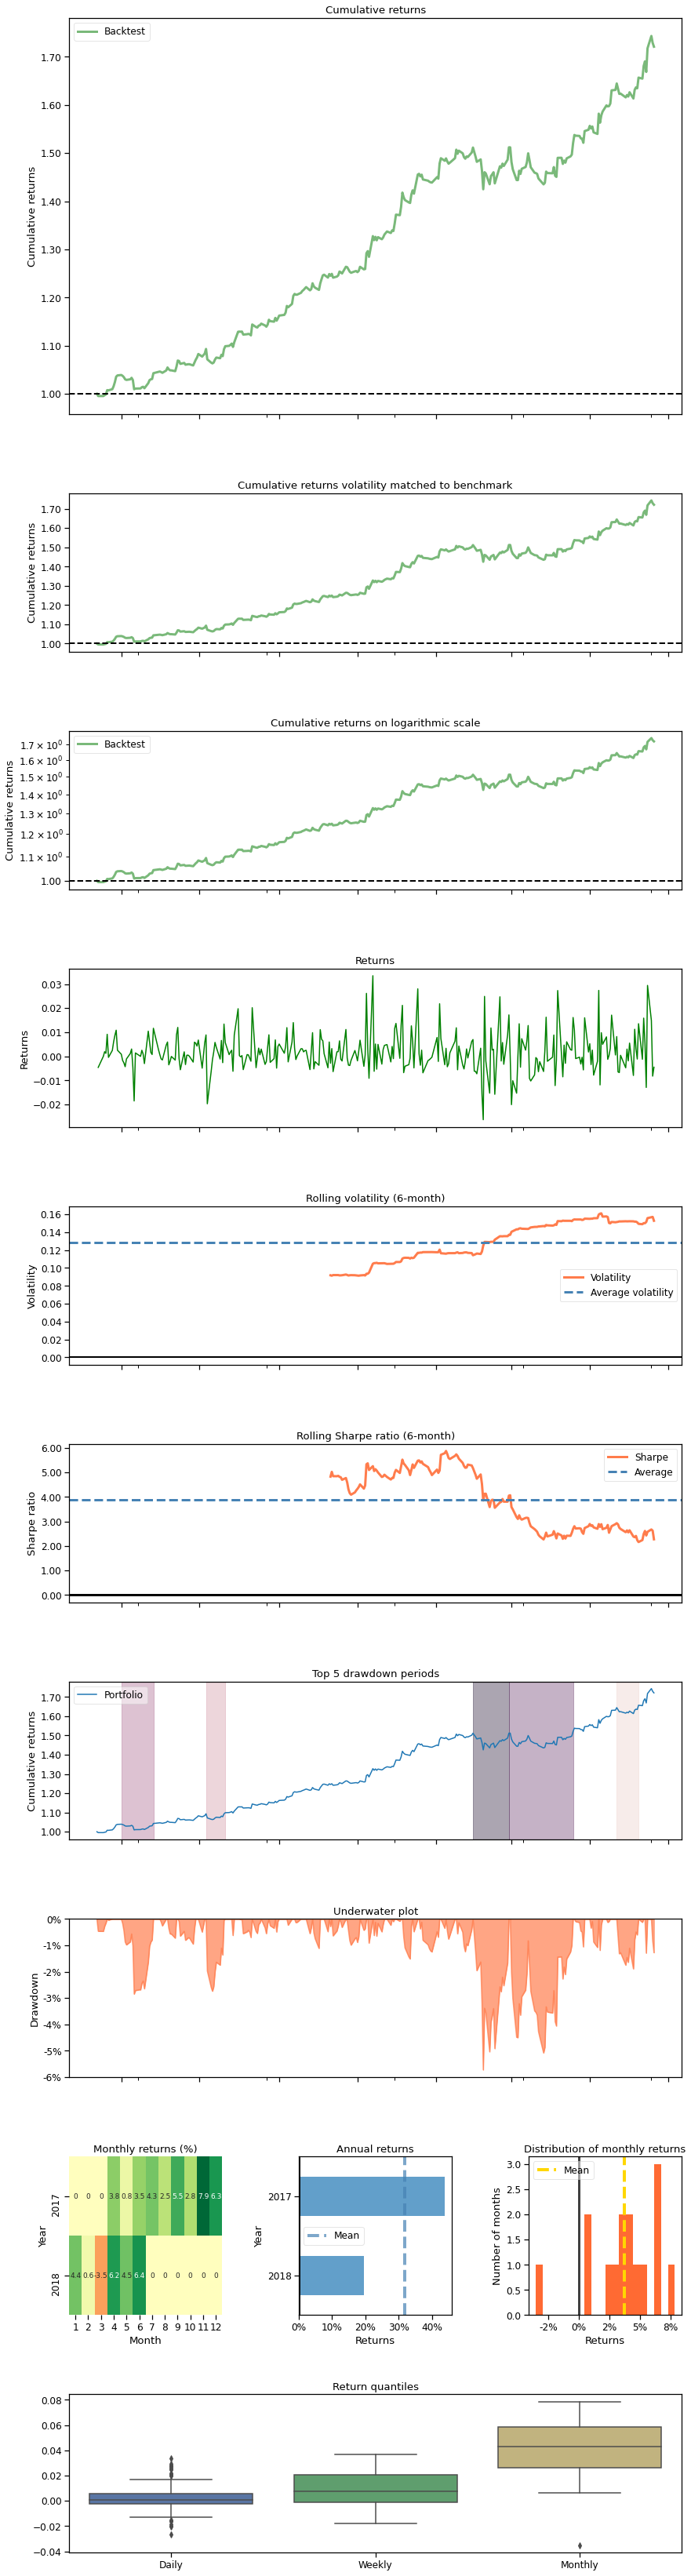

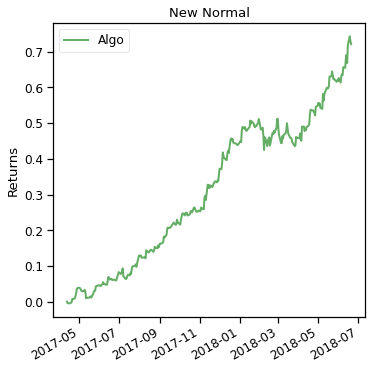

In [126]:
import warnings
warnings.filterwarnings("ignore") # ignores matplotlib warnings

%matplotlib inline
backtest_plot(net_worth_df)

In [99]:
# Note.. you may be getting an error from pyfolio. Scroll to the next section and run the cells.

## If you are getting error from pyfolio
You may be getting a "AttributeError: 'numpy.int64' object has no attribute 'to_pydatetime'" error.. Just run the cells below. Replace `PATH` with whatever the path of timeseries.py is in the error that you get (should be the path of the last error message)

In [103]:
%%writefile ~/6.884/fin-rl/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py
#
# Copyright 2018 Quantopian, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
from __future__ import division

from collections import OrderedDict
from functools import partial

import empyrical as ep
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats
from sklearn import linear_model

from .deprecate import deprecated
from .interesting_periods import PERIODS
from .txn import get_turnover
from .utils import APPROX_BDAYS_PER_MONTH, APPROX_BDAYS_PER_YEAR
from .utils import DAILY

DEPRECATION_WARNING = ("Risk functions in pyfolio.timeseries are deprecated "
                       "and will be removed in a future release. Please "
                       "install the empyrical package instead.")


def var_cov_var_normal(P, c, mu=0, sigma=1):
    """
    Variance-covariance calculation of daily Value-at-Risk in a
    portfolio.
    Parameters
    ----------
    P : float
        Portfolio value.
    c : float
        Confidence level.
    mu : float, optional
        Mean.
    Returns
    -------
    float
        Variance-covariance.
    """

    alpha = sp.stats.norm.ppf(1 - c, mu, sigma)
    return P - P * (alpha + 1)


@deprecated(msg=DEPRECATION_WARNING)
def max_drawdown(returns):
    """
    Determines the maximum drawdown of a strategy.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    Returns
    -------
    float
        Maximum drawdown.
    Note
    -----
    See https://en.wikipedia.org/wiki/Drawdown_(economics) for more details.
    """

    return ep.max_drawdown(returns)


@deprecated(msg=DEPRECATION_WARNING)
def annual_return(returns, period=DAILY):
    """
    Determines the mean annual growth rate of returns.
    Parameters
    ----------
    returns : pd.Series
        Periodic returns of the strategy, noncumulative.
        - See full explanation in :func:`~pyfolio.timeseries.cum_returns`.
    period : str, optional
        Defines the periodicity of the 'returns' data for purposes of
        annualizing. Can be 'monthly', 'weekly', or 'daily'.
        - Defaults to 'daily'.
    Returns
    -------
    float
        Annual Return as CAGR (Compounded Annual Growth Rate).
    """

    return ep.annual_return(returns, period=period)


@deprecated(msg=DEPRECATION_WARNING)
def annual_volatility(returns, period=DAILY):
    """
    Determines the annual volatility of a strategy.
    Parameters
    ----------
    returns : pd.Series
        Periodic returns of the strategy, noncumulative.
        - See full explanation in :func:`~pyfolio.timeseries.cum_returns`.
    period : str, optional
        Defines the periodicity of the 'returns' data for purposes of
        annualizing volatility. Can be 'monthly' or 'weekly' or 'daily'.
        - Defaults to 'daily'.
    Returns
    -------
    float
        Annual volatility.
    """

    return ep.annual_volatility(returns, period=period)


@deprecated(msg=DEPRECATION_WARNING)
def calmar_ratio(returns, period=DAILY):
    """
    Determines the Calmar ratio, or drawdown ratio, of a strategy.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
        - See full explanation in :func:`~pyfolio.timeseries.cum_returns`.
    period : str, optional
        Defines the periodicity of the 'returns' data for purposes of
        annualizing. Can be 'monthly', 'weekly', or 'daily'.
        - Defaults to 'daily'.
    Returns
    -------
    float
        Calmar ratio (drawdown ratio) as float. Returns np.nan if there is no
        calmar ratio.
    Note
    -----
    See https://en.wikipedia.org/wiki/Calmar_ratio for more details.
    """

    return ep.calmar_ratio(returns, period=period)


@deprecated(msg=DEPRECATION_WARNING)
def omega_ratio(returns, annual_return_threshhold=0.0):
    """
    Determines the Omega ratio of a strategy.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
        - See full explanation in :func:`~pyfolio.timeseries.cum_returns`.
    annual_return_threshold : float, optional
        Minimum acceptable return of the investor. Annual threshold over which
        returns are considered positive or negative. It is converted to a
        value appropriate for the period of the returns for this ratio.
        E.g. An annual minimum acceptable return of 100 translates to a daily
        minimum acceptable return of 0.01848.
            (1 + 100) ** (1. / 252) - 1 = 0.01848
        Daily returns must exceed this value to be considered positive. The
        daily return yields the desired annual return when compounded over
        the average number of business days in a year.
            (1 + 0.01848) ** 252 - 1 = 99.93
        - Defaults to 0.0
    Returns
    -------
    float
        Omega ratio.
    Note
    -----
    See https://en.wikipedia.org/wiki/Omega_ratio for more details.
    """

    return ep.omega_ratio(returns,
                          required_return=annual_return_threshhold)


@deprecated(msg=DEPRECATION_WARNING)
def sortino_ratio(returns, required_return=0, period=DAILY):
    """
    Determines the Sortino ratio of a strategy.
    Parameters
    ----------
    returns : pd.Series or pd.DataFrame
        Daily returns of the strategy, noncumulative.
        - See full explanation in :func:`~pyfolio.timeseries.cum_returns`.
    required_return: float / series
        minimum acceptable return
    period : str, optional
        Defines the periodicity of the 'returns' data for purposes of
        annualizing. Can be 'monthly', 'weekly', or 'daily'.
        - Defaults to 'daily'.
    Returns
    -------
    depends on input type
    series ==> float
    DataFrame ==> np.array
        Annualized Sortino ratio.
    """

    return ep.sortino_ratio(returns, required_return=required_return)


@deprecated(msg=DEPRECATION_WARNING)
def downside_risk(returns, required_return=0, period=DAILY):
    """
    Determines the downside deviation below a threshold
    Parameters
    ----------
    returns : pd.Series or pd.DataFrame
        Daily returns of the strategy, noncumulative.
        - See full explanation in :func:`~pyfolio.timeseries.cum_returns`.
    required_return: float / series
        minimum acceptable return
    period : str, optional
        Defines the periodicity of the 'returns' data for purposes of
        annualizing. Can be 'monthly', 'weekly', or 'daily'.
        - Defaults to 'daily'.
    Returns
    -------
    depends on input type
    series ==> float
    DataFrame ==> np.array
        Annualized downside deviation
    """

    return ep.downside_risk(returns,
                            required_return=required_return,
                            period=period)


@deprecated(msg=DEPRECATION_WARNING)
def sharpe_ratio(returns, risk_free=0, period=DAILY):
    """
    Determines the Sharpe ratio of a strategy.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
        - See full explanation in :func:`~pyfolio.timeseries.cum_returns`.
    risk_free : int, float
        Constant risk-free return throughout the period.
    period : str, optional
        Defines the periodicity of the 'returns' data for purposes of
        annualizing. Can be 'monthly', 'weekly', or 'daily'.
        - Defaults to 'daily'.
    Returns
    -------
    float
        Sharpe ratio.
    np.nan
        If insufficient length of returns or if if adjusted returns are 0.
    Note
    -----
    See https://en.wikipedia.org/wiki/Sharpe_ratio for more details.
    """

    return ep.sharpe_ratio(returns, risk_free=risk_free, period=period)


@deprecated(msg=DEPRECATION_WARNING)
def alpha_beta(returns, factor_returns):
    """
    Calculates both alpha and beta.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
        - See full explanation in :func:`~pyfolio.timeseries.cum_returns`.
    factor_returns : pd.Series
        Daily noncumulative returns of the benchmark factor to which betas are
        computed. Usually a benchmark such as market returns.
         - This is in the same style as returns.
    Returns
    -------
    float
        Alpha.
    float
        Beta.
    """

    return ep.alpha_beta(returns, factor_returns=factor_returns)


@deprecated(msg=DEPRECATION_WARNING)
def alpha(returns, factor_returns):
    """
    Calculates annualized alpha.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
        - See full explanation in :func:`~pyfolio.timeseries.cum_returns`.
    factor_returns : pd.Series
        Daily noncumulative returns of the benchmark factor to which betas are
        computed. Usually a benchmark such as market returns.
         - This is in the same style as returns.
    Returns
    -------
    float
        Alpha.
    """

    return ep.alpha(returns, factor_returns=factor_returns)


@deprecated(msg=DEPRECATION_WARNING)
def beta(returns, factor_returns):
    """
    Calculates beta.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
        - See full explanation in :func:`~pyfolio.timeseries.cum_returns`.
    factor_returns : pd.Series
        Daily noncumulative returns of the benchmark factor to which betas are
        computed. Usually a benchmark such as market returns.
         - This is in the same style as returns.
    Returns
    -------
    float
        Beta.
    """

    return ep.beta(returns, factor_returns)


@deprecated(msg=DEPRECATION_WARNING)
def stability_of_timeseries(returns):
    """
    Determines R-squared of a linear fit to the cumulative
    log returns. Computes an ordinary least squares linear fit,
    and returns R-squared.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
        - See full explanation in :func:`~pyfolio.timeseries.cum_returns`.
    Returns
    -------
    float
        R-squared.
    """

    return ep.stability_of_timeseries(returns)


@deprecated(msg=DEPRECATION_WARNING)
def tail_ratio(returns):
    """
    Determines the ratio between the right (95%) and left tail (5%).
    For example, a ratio of 0.25 means that losses are four times
    as bad as profits.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in :func:`~pyfolio.timeseries.cum_returns`.
    Returns
    -------
    float
        tail ratio
    """

    return ep.tail_ratio(returns)


def common_sense_ratio(returns):
    """
    Common sense ratio is the multiplication of the tail ratio and the
    Gain-to-Pain-Ratio -- sum(profits) / sum(losses).
    See http://bit.ly/1ORzGBk for more information on motivation of
    this metric.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    Returns
    -------
    float
        common sense ratio
    """

    return ep.tail_ratio(returns) * \
        (1 + ep.annual_return(returns))


def normalize(returns, starting_value=1):
    """
    Normalizes a returns timeseries based on the first value.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    starting_value : float, optional
       The starting returns (default 1).
    Returns
    -------
    pd.Series
        Normalized returns.
    """

    return starting_value * (returns / returns.iloc[0])


@deprecated(msg=DEPRECATION_WARNING)
def cum_returns(returns, starting_value=0):
    """
    Compute cumulative returns from simple returns.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    starting_value : float, optional
       The starting returns (default 1).
    Returns
    -------
    pandas.Series
        Series of cumulative returns.
    Notes
    -----
    For increased numerical accuracy, convert input to log returns
    where it is possible to sum instead of multiplying.
    """

    return ep.cum_returns(returns, starting_value=starting_value)


@deprecated(msg=DEPRECATION_WARNING)
def aggregate_returns(returns, convert_to):
    """
    Aggregates returns by week, month, or year.
    Parameters
    ----------
    returns : pd.Series
       Daily returns of the strategy, noncumulative.
        - See full explanation in :func:`~pyfolio.timeseries.cum_returns`.
    convert_to : str
        Can be 'weekly', 'monthly', or 'yearly'.
    Returns
    -------
    pd.Series
        Aggregated returns.
    """

    return ep.aggregate_returns(returns, convert_to=convert_to)


def rolling_beta(returns, factor_returns,
                 rolling_window=APPROX_BDAYS_PER_MONTH * 6):
    """
    Determines the rolling beta of a strategy.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    factor_returns : pd.Series or pd.DataFrame
        Daily noncumulative returns of the benchmark factor to which betas are
        computed. Usually a benchmark such as market returns.
         - If DataFrame is passed, computes rolling beta for each column.
         - This is in the same style as returns.
    rolling_window : int, optional
        The size of the rolling window, in days, over which to compute
        beta (default 6 months).
    Returns
    -------
    pd.Series
        Rolling beta.
    Note
    -----
    See https://en.wikipedia.org/wiki/Beta_(finance) for more details.
    """

    if factor_returns.ndim > 1:
        # Apply column-wise
        return factor_returns.apply(partial(rolling_beta, returns),
                                    rolling_window=rolling_window)
    else:
        out = pd.Series(index=returns.index)
        for beg, end in zip(returns.index[0:-rolling_window],
                            returns.index[rolling_window:]):
            out.loc[end] = ep.beta(
                returns.loc[beg:end],
                factor_returns.loc[beg:end])

        return out


def rolling_regression(returns, factor_returns,
                       rolling_window=APPROX_BDAYS_PER_MONTH * 6,
                       nan_threshold=0.1):
    """
    Computes rolling factor betas using a multivariate linear regression
    (separate linear regressions is problematic because the factors may be
    confounded).
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    factor_returns : pd.DataFrame
        Daily noncumulative returns of the benchmark factor to which betas are
        computed. Usually a benchmark such as market returns.
         - Computes rolling beta for each column.
         - This is in the same style as returns.
    rolling_window : int, optional
        The days window over which to compute the beta. Defaults to 6 months.
    nan_threshold : float, optional
        If there are more than this fraction of NaNs, the rolling regression
        for the given date will be skipped.
    Returns
    -------
    pandas.DataFrame
        DataFrame containing rolling beta coefficients to SMB, HML and UMD
    """

    # We need to drop NaNs to regress
    ret_no_na = returns.dropna()

    columns = ['alpha'] + factor_returns.columns.tolist()
    rolling_risk = pd.DataFrame(columns=columns,
                                index=ret_no_na.index)

    rolling_risk.index.name = 'dt'

    for beg, end in zip(ret_no_na.index[:-rolling_window],
                        ret_no_na.index[rolling_window:]):
        returns_period = ret_no_na[beg:end]
        factor_returns_period = factor_returns.loc[returns_period.index]

        if np.all(factor_returns_period.isnull().mean()) < nan_threshold:
            factor_returns_period_dnan = factor_returns_period.dropna()
            reg = linear_model.LinearRegression(fit_intercept=True).fit(
                factor_returns_period_dnan,
                returns_period.loc[factor_returns_period_dnan.index])
            rolling_risk.loc[end, factor_returns.columns] = reg.coef_
            rolling_risk.loc[end, 'alpha'] = reg.intercept_

    return rolling_risk


def gross_lev(positions):
    """
    Calculates the gross leverage of a strategy.
    Parameters
    ----------
    positions : pd.DataFrame
        Daily net position values.
         - See full explanation in tears.create_full_tear_sheet.
    Returns
    -------
    pd.Series
        Gross leverage.
    """

    exposure = positions.drop('cash', axis=1).abs().sum(axis=1)
    return exposure / positions.sum(axis=1)


def value_at_risk(returns, period=None, sigma=2.0):
    """
    Get value at risk (VaR).
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    period : str, optional
        Period over which to calculate VaR. Set to 'weekly',
        'monthly', or 'yearly', otherwise defaults to period of
        returns (typically daily).
    sigma : float, optional
        Standard deviations of VaR, default 2.
    """
    if period is not None:
        returns_agg = ep.aggregate_returns(returns, period)
    else:
        returns_agg = returns.copy()

    value_at_risk = returns_agg.mean() - sigma * returns_agg.std()
    return value_at_risk


SIMPLE_STAT_FUNCS = [
    ep.annual_return,
    ep.cum_returns_final,
    ep.annual_volatility,
    ep.sharpe_ratio,
    ep.calmar_ratio,
    ep.stability_of_timeseries,
    ep.max_drawdown,
    ep.omega_ratio,
    ep.sortino_ratio,
    stats.skew,
    stats.kurtosis,
    ep.tail_ratio,
    value_at_risk
]

FACTOR_STAT_FUNCS = [
    ep.alpha,
    ep.beta,
]

STAT_FUNC_NAMES = {
    'annual_return': 'Annual return',
    'cum_returns_final': 'Cumulative returns',
    'annual_volatility': 'Annual volatility',
    'sharpe_ratio': 'Sharpe ratio',
    'calmar_ratio': 'Calmar ratio',
    'stability_of_timeseries': 'Stability',
    'max_drawdown': 'Max drawdown',
    'omega_ratio': 'Omega ratio',
    'sortino_ratio': 'Sortino ratio',
    'skew': 'Skew',
    'kurtosis': 'Kurtosis',
    'tail_ratio': 'Tail ratio',
    'common_sense_ratio': 'Common sense ratio',
    'value_at_risk': 'Daily value at risk',
    'alpha': 'Alpha',
    'beta': 'Beta',
}


def perf_stats(returns, factor_returns=None, positions=None,
               transactions=None, turnover_denom='AGB'):
    """
    Calculates various performance metrics of a strategy, for use in
    plotting.show_perf_stats.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    factor_returns : pd.Series, optional
        Daily noncumulative returns of the benchmark factor to which betas are
        computed. Usually a benchmark such as market returns.
         - This is in the same style as returns.
         - If None, do not compute alpha, beta, and information ratio.
    positions : pd.DataFrame
        Daily net position values.
         - See full explanation in tears.create_full_tear_sheet.
    transactions : pd.DataFrame
        Prices and amounts of executed trades. One row per trade.
        - See full explanation in tears.create_full_tear_sheet.
    turnover_denom : str
        Either AGB or portfolio_value, default AGB.
        - See full explanation in txn.get_turnover.
    Returns
    -------
    pd.Series
        Performance metrics.
    """

    stats = pd.Series()
    for stat_func in SIMPLE_STAT_FUNCS:
        stats[STAT_FUNC_NAMES[stat_func.__name__]] = stat_func(returns)

    if positions is not None:
        stats['Gross leverage'] = gross_lev(positions).mean()
        if transactions is not None:
            stats['Daily turnover'] = get_turnover(positions,
                                                   transactions,
                                                   turnover_denom).mean()
    if factor_returns is not None:
        for stat_func in FACTOR_STAT_FUNCS:
            res = stat_func(returns, factor_returns)
            stats[STAT_FUNC_NAMES[stat_func.__name__]] = res

    return stats


def perf_stats_bootstrap(returns, factor_returns=None, return_stats=True,
                         **kwargs):
    """Calculates various bootstrapped performance metrics of a strategy.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    factor_returns : pd.Series, optional
        Daily noncumulative returns of the benchmark factor to which betas are
        computed. Usually a benchmark such as market returns.
         - This is in the same style as returns.
         - If None, do not compute alpha, beta, and information ratio.
    return_stats : boolean (optional)
        If True, returns a DataFrame of mean, median, 5 and 95 percentiles
        for each perf metric.
        If False, returns a DataFrame with the bootstrap samples for
        each perf metric.
    Returns
    -------
    pd.DataFrame
        if return_stats is True:
        - Distributional statistics of bootstrapped sampling
        distribution of performance metrics.
        if return_stats is False:
        - Bootstrap samples for each performance metric.
    """

    bootstrap_values = OrderedDict()

    for stat_func in SIMPLE_STAT_FUNCS:
        stat_name = STAT_FUNC_NAMES[stat_func.__name__]
        bootstrap_values[stat_name] = calc_bootstrap(stat_func,
                                                     returns)

    if factor_returns is not None:
        for stat_func in FACTOR_STAT_FUNCS:
            stat_name = STAT_FUNC_NAMES[stat_func.__name__]
            bootstrap_values[stat_name] = calc_bootstrap(
                stat_func,
                returns,
                factor_returns=factor_returns)

    bootstrap_values = pd.DataFrame(bootstrap_values)

    if return_stats:
        stats = bootstrap_values.apply(calc_distribution_stats)
        return stats.T[['mean', 'median', '5%', '95%']]
    else:
        return bootstrap_values


def calc_bootstrap(func, returns, *args, **kwargs):
    """Performs a bootstrap analysis on a user-defined function returning
    a summary statistic.
    Parameters
    ----------
    func : function
        Function that either takes a single array (commonly returns)
        or two arrays (commonly returns and factor returns) and
        returns a single value (commonly a summary
        statistic). Additional args and kwargs are passed as well.
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    factor_returns : pd.Series, optional
        Daily noncumulative returns of the benchmark factor to which betas are
        computed. Usually a benchmark such as market returns.
         - This is in the same style as returns.
    n_samples : int, optional
        Number of bootstrap samples to draw. Default is 1000.
        Increasing this will lead to more stable / accurate estimates.
    Returns
    -------
    numpy.ndarray
        Bootstrapped sampling distribution of passed in func.
    """

    n_samples = kwargs.pop('n_samples', 1000)
    out = np.empty(n_samples)

    factor_returns = kwargs.pop('factor_returns', None)

    for i in range(n_samples):
        idx = np.random.randint(len(returns), size=len(returns))
        returns_i = returns.iloc[idx].reset_index(drop=True)
        if factor_returns is not None:
            factor_returns_i = factor_returns.iloc[idx].reset_index(drop=True)
            out[i] = func(returns_i, factor_returns_i,
                          *args, **kwargs)
        else:
            out[i] = func(returns_i,
                          *args, **kwargs)

    return out


def calc_distribution_stats(x):
    """Calculate various summary statistics of data.
    Parameters
    ----------
    x : numpy.ndarray or pandas.Series
        Array to compute summary statistics for.
    Returns
    -------
    pandas.Series
        Series containing mean, median, std, as well as 5, 25, 75 and
        95 percentiles of passed in values.
    """

    return pd.Series({'mean': np.mean(x),
                      'median': np.median(x),
                      'std': np.std(x),
                      '5%': np.percentile(x, 5),
                      '25%': np.percentile(x, 25),
                      '75%': np.percentile(x, 75),
                      '95%': np.percentile(x, 95),
                      'IQR': np.subtract.reduce(
                          np.percentile(x, [75, 25])),
                      })


def get_max_drawdown_underwater(underwater):
    """
    Determines peak, valley, and recovery dates given an 'underwater'
    DataFrame.
    An underwater DataFrame is a DataFrame that has precomputed
    rolling drawdown.
    Parameters
    ----------
    underwater : pd.Series
       Underwater returns (rolling drawdown) of a strategy.
    Returns
    -------
    peak : datetime
        The maximum drawdown's peak.
    valley : datetime
        The maximum drawdown's valley.
    recovery : datetime
        The maximum drawdown's recovery.
    """

    valley = underwater.index[np.argmin(underwater)] # end of the period
    # Find first 0
    peak = underwater[:valley][underwater[:valley] == 0].index[-1]
    # Find last 0
    try:
        recovery = underwater[valley:][underwater[valley:] == 0].index[0]
    except IndexError:
        recovery = np.nan  # drawdown not recovered
    return peak, valley, recovery


def get_max_drawdown(returns):
    """
    Determines the maximum drawdown of a strategy.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
        - See full explanation in :func:`~pyfolio.timeseries.cum_returns`.
    Returns
    -------
    float
        Maximum drawdown.
    Note
    -----
    See https://en.wikipedia.org/wiki/Drawdown_(economics) for more details.
    """

    returns = returns.copy()
    df_cum = cum_returns(returns, 1.0)
    running_max = np.maximum.accumulate(df_cum)
    underwater = df_cum / running_max - 1
    return get_max_drawdown_underwater(underwater)


def get_top_drawdowns(returns, top=10):
    """
    Finds top drawdowns, sorted by drawdown amount.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    top : int, optional
        The amount of top drawdowns to find (default 10).
    Returns
    -------
    drawdowns : list
        List of drawdown peaks, valleys, and recoveries. See get_max_drawdown.
    """

    returns = returns.copy()
    df_cum = ep.cum_returns(returns, 1.0)
    running_max = np.maximum.accumulate(df_cum)
    underwater = df_cum / running_max - 1

    drawdowns = []
    for _ in range(top):
        peak, valley, recovery = get_max_drawdown_underwater(underwater)
        # Slice out draw-down period
        if not pd.isnull(recovery):
            underwater.drop(underwater[peak: recovery].index[1:-1],
                            inplace=True)
        else:
            # drawdown has not ended yet
            underwater = underwater.loc[:peak]

        drawdowns.append((peak, valley, recovery))
        if ((len(returns) == 0)
                or (len(underwater) == 0)
                or (np.min(underwater) == 0)):
            break

    return drawdowns


def gen_drawdown_table(returns, top=10):
    """
    Places top drawdowns in a table.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    top : int, optional
        The amount of top drawdowns to find (default 10).
    Returns
    -------
    df_drawdowns : pd.DataFrame
        Information about top drawdowns.
    """

    df_cum = ep.cum_returns(returns, 1.0)
    drawdown_periods = get_top_drawdowns(returns, top=top)
    df_drawdowns = pd.DataFrame(index=list(range(top)),
                                columns=['Net drawdown in %',
                                         'Peak date',
                                         'Valley date',
                                         'Recovery date',
                                         'Duration'])

    for i, (peak, valley, recovery) in enumerate(drawdown_periods):
        if pd.isnull(recovery):
            df_drawdowns.loc[i, 'Duration'] = np.nan
        else:
            df_drawdowns.loc[i, 'Duration'] = len(pd.date_range(peak,
                                                                recovery,
                                                                freq='B'))
        df_drawdowns.loc[i, 'Peak date'] = (pd.to_datetime(peak))
        df_drawdowns.loc[i, 'Valley date'] = (pd.to_datetime(valley))
        if isinstance(recovery, float):
            df_drawdowns.loc[i, 'Recovery date'] = recovery
        else:
            df_drawdowns.loc[i, 'Recovery date'] = (pd.to_datetime(recovery))
        df_drawdowns.loc[i, 'Net drawdown in %'] = (
            (df_cum.loc[peak] - df_cum.loc[valley]) / df_cum.loc[peak]) * 100

    df_drawdowns['Peak date'] = pd.to_datetime(df_drawdowns['Peak date'])
    df_drawdowns['Valley date'] = pd.to_datetime(df_drawdowns['Valley date'])
    df_drawdowns['Recovery date'] = pd.to_datetime(
        df_drawdowns['Recovery date'])

    return df_drawdowns


def rolling_volatility(returns, rolling_vol_window):
    """
    Determines the rolling volatility of a strategy.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    rolling_vol_window : int
        Length of rolling window, in days, over which to compute.
    Returns
    -------
    pd.Series
        Rolling volatility.
    """

    return returns.rolling(rolling_vol_window).std() \
        * np.sqrt(APPROX_BDAYS_PER_YEAR)


def rolling_sharpe(returns, rolling_sharpe_window):
    """
    Determines the rolling Sharpe ratio of a strategy.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    rolling_sharpe_window : int
        Length of rolling window, in days, over which to compute.
    Returns
    -------
    pd.Series
        Rolling Sharpe ratio.
    Note
    -----
    See https://en.wikipedia.org/wiki/Sharpe_ratio for more details.
    """

    return returns.rolling(rolling_sharpe_window).mean() \
        / returns.rolling(rolling_sharpe_window).std() \
        * np.sqrt(APPROX_BDAYS_PER_YEAR)


def simulate_paths(is_returns, num_days,
                   starting_value=1, num_samples=1000, random_seed=None):
    """
    Gnerate alternate paths using available values from in-sample returns.
    Parameters
    ----------
    is_returns : pandas.core.frame.DataFrame
        Non-cumulative in-sample returns.
    num_days : int
        Number of days to project the probability cone forward.
    starting_value : int or float
        Starting value of the out of sample period.
    num_samples : int
        Number of samples to draw from the in-sample daily returns.
        Each sample will be an array with length num_days.
        A higher number of samples will generate a more accurate
        bootstrap cone.
    random_seed : int
        Seed for the pseudorandom number generator used by the pandas
        sample method.
    Returns
    -------
    samples : numpy.ndarray
    """

    samples = np.empty((num_samples, num_days))
    seed = np.random.RandomState(seed=random_seed)
    for i in range(num_samples):
        samples[i, :] = is_returns.sample(num_days, replace=True,
                                          random_state=seed)

    return samples


def summarize_paths(samples, cone_std=(1., 1.5, 2.), starting_value=1.):
    """
    Gnerate the upper and lower bounds of an n standard deviation
    cone of forecasted cumulative returns.
    Parameters
    ----------
    samples : numpy.ndarray
        Alternative paths, or series of possible outcomes.
    cone_std : list of int/float
        Number of standard devations to use in the boundaries of
        the cone. If multiple values are passed, cone bounds will
        be generated for each value.
    Returns
    -------
    samples : pandas.core.frame.DataFrame
    """

    cum_samples = ep.cum_returns(samples.T,
                                 starting_value=starting_value).T

    cum_mean = cum_samples.mean(axis=0)
    cum_std = cum_samples.std(axis=0)

    if isinstance(cone_std, (float, int)):
        cone_std = [cone_std]

    cone_bounds = pd.DataFrame(columns=pd.Float64Index([]))
    for num_std in cone_std:
        cone_bounds.loc[:, float(num_std)] = cum_mean + cum_std * num_std
        cone_bounds.loc[:, float(-num_std)] = cum_mean - cum_std * num_std

    return cone_bounds


def forecast_cone_bootstrap(is_returns, num_days, cone_std=(1., 1.5, 2.),
                            starting_value=1, num_samples=1000,
                            random_seed=None):
    """
    Determines the upper and lower bounds of an n standard deviation
    cone of forecasted cumulative returns. Future cumulative mean and
    standard devation are computed by repeatedly sampling from the
    in-sample daily returns (i.e. bootstrap). This cone is non-parametric,
    meaning it does not assume that returns are normally distributed.
    Parameters
    ----------
    is_returns : pd.Series
        In-sample daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    num_days : int
        Number of days to project the probability cone forward.
    cone_std : int, float, or list of int/float
        Number of standard devations to use in the boundaries of
        the cone. If multiple values are passed, cone bounds will
        be generated for each value.
    starting_value : int or float
        Starting value of the out of sample period.
    num_samples : int
        Number of samples to draw from the in-sample daily returns.
        Each sample will be an array with length num_days.
        A higher number of samples will generate a more accurate
        bootstrap cone.
    random_seed : int
        Seed for the pseudorandom number generator used by the pandas
        sample method.
    Returns
    -------
    pd.DataFrame
        Contains upper and lower cone boundaries. Column names are
        strings corresponding to the number of standard devations
        above (positive) or below (negative) the projected mean
        cumulative returns.
    """

    samples = simulate_paths(
        is_returns=is_returns,
        num_days=num_days,
        starting_value=starting_value,
        num_samples=num_samples,
        random_seed=random_seed
    )

    cone_bounds = summarize_paths(
        samples=samples,
        cone_std=cone_std,
        starting_value=starting_value
    )

    return cone_bounds


def extract_interesting_date_ranges(returns, periods=None):
    """
    Extracts returns based on interesting events. See
    gen_date_range_interesting.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    Returns
    -------
    ranges : OrderedDict
        Date ranges, with returns, of all valid events.
    """
    if periods is None:
        periods = PERIODS
    returns_dupe = returns.copy()
    returns_dupe.index = returns_dupe.index.map(pd.Timestamp)
    ranges = OrderedDict()
    for name, (start, end) in periods.items():
        try:
            period = returns_dupe.loc[start:end]
            if len(period) == 0:
                continue
            ranges[name] = period
        except BaseException:
            continue

    return ranges

Overwriting /home/kying/6.884/fin-rl/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py


In [104]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
